In [1]:
import pandas as pd
import numpy as np
import zipfile

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['toolbar'] = 'None' 

#### Loading data from zip files

In [2]:
z = zipfile.ZipFile('data/training.zip')
train = pd.read_csv(z.open('training.csv'))
z = zipfile.ZipFile('data/test.zip')
test = pd.read_csv(z.open('test.csv'))

convert images

In [3]:
train.Image2 = train.Image.apply(lambda im: np.fromstring(im, sep=' ').reshape(96,96))
test.Image2 = test.Image.apply(lambda im: np.fromstring(im, sep=' ').reshape(96,96))

Take a brief look on data

In [4]:
train[train.columns[0:-1]].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [5]:
def plot_sample(x, y, axis):
    plt.imshow(x, cmap='gray')
    plt.scatter(y[0::2], y[1::2], marker='x', s=10)

In [6]:
keypoints_columns = train.columns[0:-1]

<IPython.core.display.Javascript object>


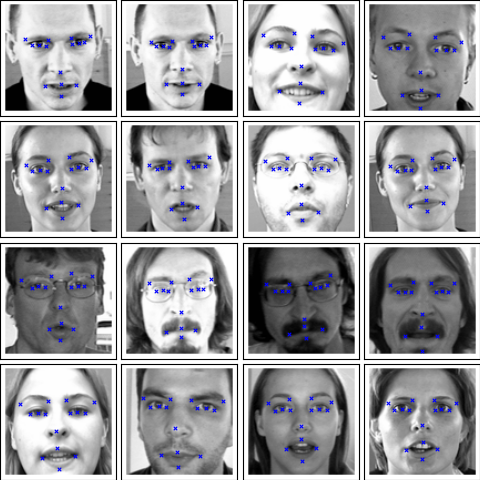

In [7]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16,32):
    ax = fig.add_subplot(4, 4, (i%16) + 1, xticks=[], yticks=[])
    plot_sample(train.Image2[i], train[keypoints_columns].iloc[i].values, ax)
    



# Simple avg benchmark

Calculate average value for each keypoint and use this value as result

In [19]:
benchmark = train[keypoints_columns].mean()
benchmark.head()

left_eye_center_x          66.359021
left_eye_center_y          37.651234
right_eye_center_x         30.306102
right_eye_center_y         37.976943
left_eye_inner_corner_x    59.159339
dtype: float64

Load IdLookupTable

In [9]:
idLookUp = pd.read_csv('data/IdLookupTable.csv')
idLookUp.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [10]:
idLookUp[(idLookUp.ImageId==1) & (idLookUp.FeatureName=='right_eye_center_x')].RowId.values[0]

3

In [48]:
rowids = [ row.RowId for index,row in idLookUp.iterrows()]
values_benchmark = [ benchmark[row.FeatureName] for index,row in idLookUp.iterrows()]

In [53]:
benchmark_submission = pd.DataFrame(values_benchmark, index=rowids, columns=['Location'])
benchmark_submission.index.name='RowId'
benchmark_submission.head()

,Location
RowId,
1,66.359021
2,37.651234
3,30.306102
4,37.976943
5,59.159339


In [54]:
benchmark_submission.to_csv('submissions/benchmark.csv')